In [1]:
import sys
sys.path.insert(0,'/cis/home/leebc/Projects/Mouse_Histology/code/pytorch/') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk

SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Below we use the third resampling method.

The goal is to make the target file (the SMI file) the same as the MRI file

(0.004000000189989805, 0.004000000189989805, 1.0)
(220, 116, 14)
[98.23226112 59.23475875  6.57543992] target
[392.27772958 198.87809045  23.36704865] mri


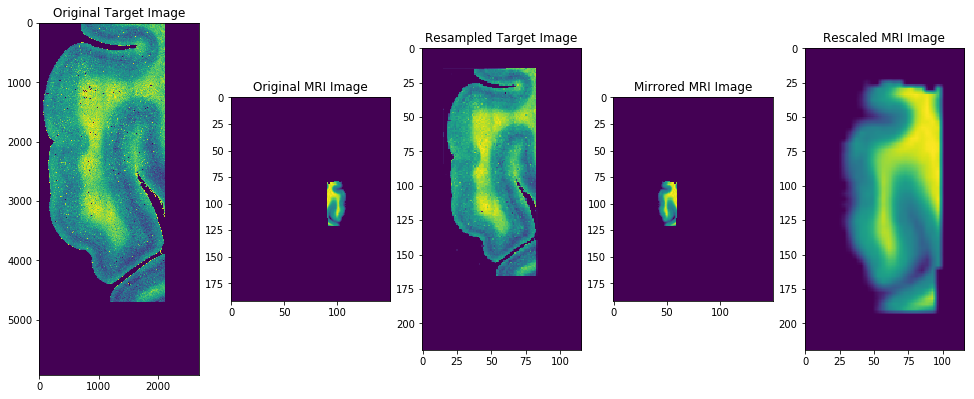

In [2]:
# load mouse brain histology and mri images
target_file_name = '/cis/home/jtrieu/Documents/WK0145_SMI_v5_reversed.img'
mri_file_name = '/cis/home/jtrieu/Documents//WK0145_20191120.img'

# resample target file to make it the same size as the mri file
mri_sitk = sitk.ReadImage(mri_file_name)    
target_sitk = sitk.ReadImage(target_file_name)

# removing the 4th dimension from the target file
target_data = sitk.GetArrayFromImage(target_sitk)
target_data = np.squeeze(target_data)
target_3D = sitk.GetImageFromArray(target_data)
target_3D.SetSpacing([target_sitk.GetSpacing()[0],target_sitk.GetSpacing()[1],target_sitk.GetSpacing()[3]])

# save the new 3D target image
sitk.WriteImage(target_3D,'/cis/home/jtrieu/Documents/WK0145_3D_SMI_v5_reversed.img')

# update target file name
target_file_name = '/cis/home/jtrieu/Documents/WK0145_3D_SMI_v5_reversed.img'

# read in new target that's been reduced from 4->3 dimensions
target_sitk = sitk.ReadImage(target_file_name)
print(target_sitk.GetSpacing())

# resample the target image
#output_size = [mri_sitk.GetSize()[0],mri_sitk.GetSize()[1],target_3D.GetSize()[2]]
output_spacing = [mri_sitk.GetSpacing()[0]/4,mri_sitk.GetSpacing()[1]/4,target_3D.GetSpacing()[2]]
output_size = [int(np.round(target_3D.GetSize()[0]*target_3D.GetSpacing()[0]/output_spacing[0])),
               int(np.round(target_3D.GetSize()[1]*target_3D.GetSpacing()[1]/output_spacing[1])),
               target_3D.GetSize()[2]]
target_resample = sitk.Resample(sitk.SmoothingRecursiveGaussian(target_3D,
                                                                target_3D.GetSpacing()[0]*2),
                                                                output_size,
                                                                sitk.AffineTransform(3),
                                                                sitk.sitkLinear,
                                                                (0,0,0),
                                                                output_spacing,
                                                                (1,0,0,0,1,0,0,0,1), 0.0)

# pad the resampled target
target_resample_np = np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))
pad_amount = [15,15,4]
target_padded_np = np.zeros((target_resample_np.shape[0]+pad_amount[0]*2,target_resample_np.shape[1]+pad_amount[1]*2,target_resample_np.shape[2]+pad_amount[2]*2))
target_padded_np[pad_amount[0]:-pad_amount[0],pad_amount[1]:-pad_amount[1],pad_amount[2]:-pad_amount[2]] = target_resample_np

target_resample = sitk.GetImageFromArray(np.transpose(target_padded_np,(2,1,0)))
target_resample.SetSpacing(output_spacing)

print(target_resample.GetSize())

# save the new 3D target resampled image
sitk.WriteImage(target_resample,'/cis/home/jtrieu/Documents/WK0145_3D_SMI_resampled.img')

# update target file name to new 3D target resampled image
target_file_name = '/cis/home/jtrieu/Documents/WK0145_3D_SMI_resampled.img'

# load mri and target data into numpy arrays
target_image_struct = nib.load(target_file_name)
mri_image_struct = nib.load(mri_file_name)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)
mri_image = np.squeeze(mri_image_struct.get_data()).astype(np.float32)

mri_image_mirrored = mri_image[:,mri_image.shape[1]:None:-1,:] # mirror mri in y dimension
mri_image_mirrored_sitk = sitk.GetImageFromArray(np.transpose(mri_image_mirrored,(2,1,0)))
mri_image_mirrored_sitk.SetSpacing(mri_sitk.GetSpacing())
mri_output_size = [int(np.round(mri_sitk.GetSize()[0]*mri_sitk.GetSpacing()[0]/output_spacing[0])),int(np.round(mri_sitk.GetSize()[1]*mri_sitk.GetSpacing()[1]/output_spacing[1])),int(np.round(mri_sitk.GetSize()[2]*mri_sitk.GetSpacing()[2]/output_spacing[2]))]
mri_resample = sitk.Resample(mri_image_mirrored_sitk, mri_output_size, sitk.AffineTransform(3), sitk.sitkLinear,
                             (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

target_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)))),axis=1)
mri_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)))),axis=1)
print(target_center_of_mass, 'target')
print(mri_center_of_mass,'mri')

# plot translated, resampled target image
translation = sitk.TranslationTransform(3)
translation.SetOffset((-(target_center_of_mass[0]-mri_center_of_mass[0])*mri_resample.GetSpacing()[0],
                       -(target_center_of_mass[1]-mri_center_of_mass[1])*mri_resample.GetSpacing()[1],
                       -(target_center_of_mass[2]-mri_center_of_mass[2])*mri_resample.GetSpacing()[2]))
mri_transform = sitk.Resample(mri_resample, target_resample.GetSize(), translation, sitk.sitkLinear,
                                 (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()

# plot original target image
plt.subplot(1,6,1)
plt.title('Original Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_3D),(2,1,0))[:,:,1])

# plot original mri image
plt.subplot(1,6,2)
plt.imshow(mri_image[:,:,36])
plt.title('Original MRI Image')

# plot resampled target image
plt.subplot(1,6,3)
plt.title('Resampled Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))[:,:,5])

# plot mirrored mri image
plt.subplot(1,6,4)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_image_mirrored_sitk),(2,1,0))[:,:,36])
plt.title('Mirrored MRI Image')

plt.subplot(1,6,5)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_transform),(2,1,0))[:,:,1])
plt.title('Rescaled MRI Image')
plt.show()


sitk.WriteImage(target_resample,'/cis/home/jtrieu/Documents/target_resample.img')
sitk.WriteImage(mri_transform,'/cis/home/jtrieu/Documents/mri_transform.img')


## Start with alignment to self

In [15]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[target_resample_arr],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=0,gpu_number = None,checkaffinestep=1)
lddmm._checkParameters()
lddmm._load(lddmm.params['template'],lddmm.params['target'],lddmm.params['costmask'])
lddmm.initializeVariables()
lddmm.initializeKernels()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

In [16]:
# Grab the indices of the missing slices
missingslices = []
for i in range(target_resample_arr.shape[2]):
    if np.unique(target_image[:,:,i]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


#origJ = lddmm.J[0].clone()
epsilonxy = 4e-7
epsilontheta=2e-7
a = None
b = None
theta = None
niter = 500

a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_resample_arr).type(torch.FloatTensor),torch.tensor(target_resample_arr).type(torch.FloatTensor),niter=niter,dim=2,norm=0,missingslices=missingslices,sigma_atlas=99999999999.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_resample_arr.shape),dx=output_spacing,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4, sigma_target_radius=1, sigma_atlas_radius=1)
#lddmm.setParams('a',4)
outtarget = lddmm.applySA(torch.tensor(target_resample_arr).type(torch.FloatTensor), a, b, theta, dim=2,nx=list(target_resample_arr.shape),dx=output_spacing).numpy().astype(np.float32)

[0, 1, 2, 3, 10, 11, 12, 13]
iter: 1, E= 2119.716, Eim_t= 2119.716, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 2118.647, Eim_t= 2118.647, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 3, E= 2115.562, Eim_t= 2115.562, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 4, E= 2114.664, Eim_t= 2114.664, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 5, E= 2111.440, Eim_t= 2111.440, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 6, E= 2110.529, Eim_t= 2110.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 7, E= 2107.362, Eim_t= 2107.362, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 8, E= 2106.433, Eim_t= 2106.433, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 9

iter: 71, E= 1976.705, Eim_t= 1976.699, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 72, E= 1974.351, Eim_t= 1974.345, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 73, E= 1972.098, Eim_t= 1972.092, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 74, E= 1969.687, Eim_t= 1969.680, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 75, E= 1967.509, Eim_t= 1967.501, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 76, E= 1965.055, Eim_t= 1965.048, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 77, E= 1962.984, Eim_t= 1962.976, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 78, E= 1960.499, Eim_t= 1960.491, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 79, E= 195

iter: 143, E= 1804.988, Eim_t= 1804.968, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 144, E= 1798.583, Eim_t= 1798.563, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 145, E= 1798.171, Eim_t= 1798.151, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 146, E= 1791.548, Eim_t= 1791.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 147, E= 1791.163, Eim_t= 1791.144, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0187, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 148, E= 1784.298, Eim_t= 1784.279, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0187, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 149, E= 1783.928, Eim_t= 1783.909, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0185, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 150, E= 1776.773, Eim_t= 1776.755, Eim_a= 0.000, ER_xy= 0.001, ER_t= 0.0185, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 15

iter: 215, E= 1447.218, Eim_t= 1447.202, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 216, E= 1441.680, Eim_t= 1441.664, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 217, E= 1440.949, Eim_t= 1440.933, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 218, E= 1435.932, Eim_t= 1435.915, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 219, E= 1435.431, Eim_t= 1435.415, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 220, E= 1430.892, Eim_t= 1430.876, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 221, E= 1430.230, Eim_t= 1430.214, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 222, E= 1426.151, Eim_t= 1426.135, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 22

iter: 287, E= 1329.875, Eim_t= 1329.858, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0063, ep_xy= 0.0004, ep_t= 0.0000, time= 0.04.
iter: 288, E= 1328.512, Eim_t= 1328.495, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0063, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 289, E= 1328.471, Eim_t= 1328.454, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0062, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 290, E= 1327.308, Eim_t= 1327.291, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0062, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 291, E= 1327.268, Eim_t= 1327.251, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0061, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 292, E= 1326.199, Eim_t= 1326.182, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0061, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 293, E= 1326.162, Eim_t= 1326.145, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0059, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 294, E= 1325.194, Eim_t= 1325.177, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0059, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 29

iter: 359, E= 1319.245, Eim_t= 1319.227, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0007, ep_t= 0.0000, time= 0.04.
iter: 360, E= 1318.976, Eim_t= 1318.959, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 361, E= 1318.976, Eim_t= 1318.958, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 362, E= 1318.763, Eim_t= 1318.746, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 363, E= 1318.763, Eim_t= 1318.746, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 364, E= 1318.737, Eim_t= 1318.719, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 365, E= 1318.737, Eim_t= 1318.719, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 366, E= 1318.662, Eim_t= 1318.644, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0009, ep_t= 0.0000, time= 0.04.
iter: 36

iter: 431, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 432, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 433, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 434, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 435, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 436, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 437, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 438, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 43

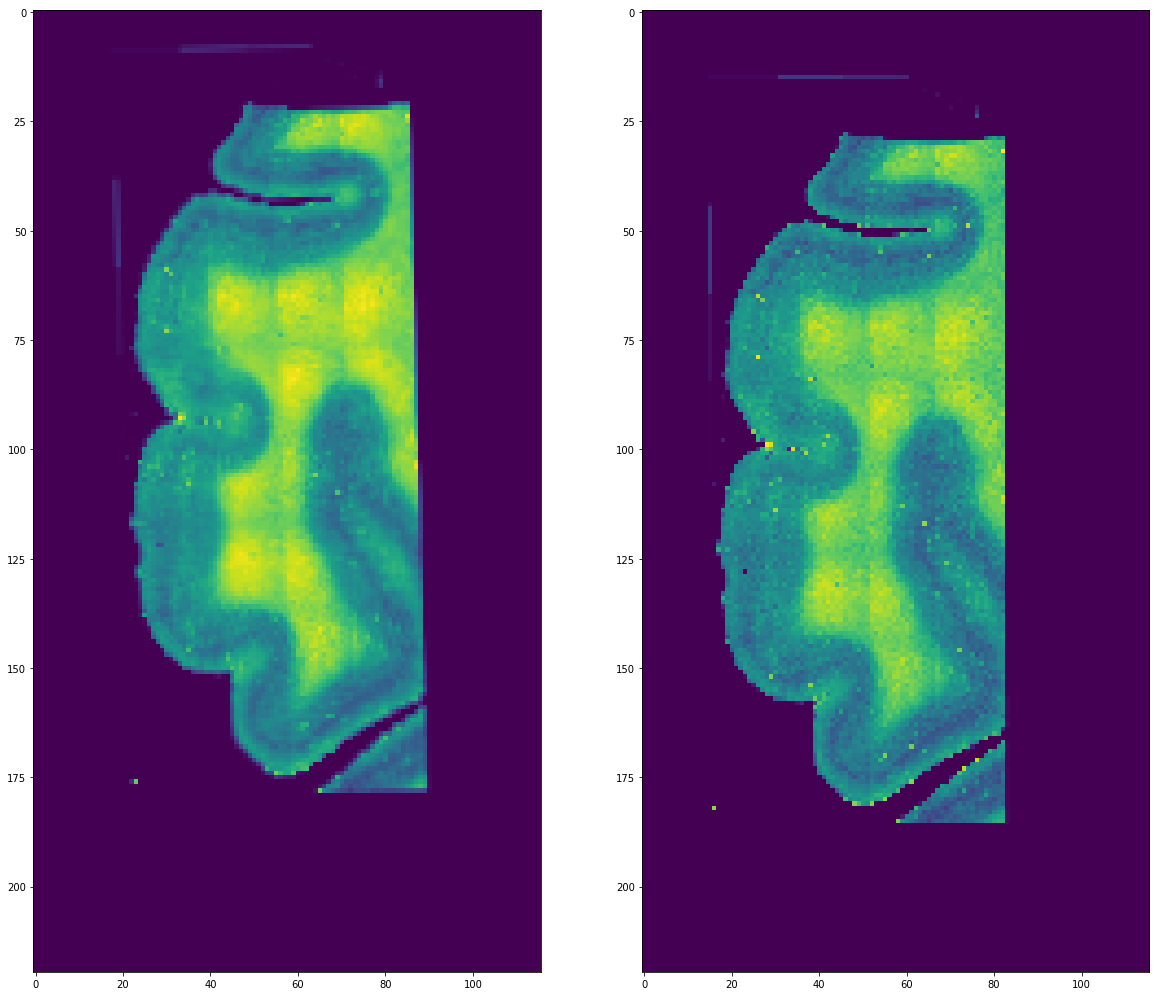

In [17]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(outtarget[:,:,6])
plt.subplot(1,2,2)
plt.imshow(target_resample_arr[:,:,6])
plt.show()

In [18]:
# check image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = output_spacing
nib.save(outimg,'/cis/home/jtrieu/Documents/target_resectioned.img')

## Start with rigid alignment

In [19]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

mri_transform_arr[:,:,9:] = 0
mri_translated = np.zeros(mri_transform_arr.shape)
mri_translated[:,:,3:-3] = mri_transform_arr[:,:,0:8]


costmask = np.zeros(target_resample_arr.shape)
costmask[np.where(target_resample_arr != 0)] = 1

print(np.max(mri_transform_arr))
print(np.max(outtarget))
print(np.min(mri_transform_arr))
print(np.min(outtarget))

lddmm = torch_lddmm.LDDMM(template=[mri_translated],target=[outtarget],costmask=costmask,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=1,gpu_number = 1)

213.75468
198.93884
0.0
-0.1435687

Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
> 

In [20]:
%%time
lddmm.setParams('niter',500)
# translation
lddmm.setParams('epsilonL',1e-99)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()
# translation + rotation
lddmm.setParams('epsilonL',1e-5)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()
# affine
lddmm.setParams('do_affine',1)
lddmm.setParams('epsilonL',1e-5)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()

Parameter 'niter' changed to '500'.
Parameter 'epsilonL' changed to '1e-99'.
Parameter 'epsilonT' changed to '2e-05'.
iter: 0, E = 3658.8354, ER = 0.0000, EM = 3658.8354, epd = 0.005000.
iter: 1, E= 3649.284, ER= 0.000, EM= 3649.284, epd= 0.005, time= 0.05s.
iter: 2, E= 3639.774, ER= 0.000, EM= 3639.774, epd= 0.005, time= 0.04s.
iter: 3, E= 3630.312, ER= 0.000, EM= 3630.312, epd= 0.005, time= 0.04s.
iter: 4, E= 3620.901, ER= 0.000, EM= 3620.901, epd= 0.005, time= 0.03s.
iter: 5, E= 3611.547, ER= 0.000, EM= 3611.547, epd= 0.005, time= 0.03s.
iter: 6, E= 3602.253, ER= 0.000, EM= 3602.253, epd= 0.005, time= 0.03s.
iter: 7, E= 3593.025, ER= 0.000, EM= 3593.025, epd= 0.005, time= 0.03s.
iter: 8, E= 3583.867, ER= 0.000, EM= 3583.867, epd= 0.005, time= 0.03s.
iter: 9, E= 3574.783, ER= 0.000, EM= 3574.783, epd= 0.005, time= 0.03s.
iter: 10, E= 3565.780, ER= 0.000, EM= 3565.780, epd= 0.005, time= 0.03s.
iter: 11, E= 3556.861, ER= 0.000, EM= 3556.861, epd= 0.005, time= 0.03s.
iter: 12, E= 3548.0

iter: 117, E= 2666.337, ER= 0.000, EM= 2666.337, epd= 0.005, time= 0.03s.
iter: 118, E= 2662.721, ER= 0.000, EM= 2662.721, epd= 0.005, time= 0.03s.
iter: 119, E= 2659.259, ER= 0.000, EM= 2659.259, epd= 0.005, time= 0.03s.
iter: 120, E= 2655.948, ER= 0.000, EM= 2655.948, epd= 0.005, time= 0.03s.
iter: 121, E= 2652.784, ER= 0.000, EM= 2652.784, epd= 0.005, time= 0.03s.
iter: 122, E= 2649.764, ER= 0.000, EM= 2649.764, epd= 0.005, time= 0.03s.
iter: 123, E= 2646.884, ER= 0.000, EM= 2646.884, epd= 0.005, time= 0.03s.
iter: 124, E= 2644.141, ER= 0.000, EM= 2644.141, epd= 0.005, time= 0.03s.
iter: 125, E= 2641.530, ER= 0.000, EM= 2641.530, epd= 0.005, time= 0.03s.
iter: 126, E= 2639.049, ER= 0.000, EM= 2639.049, epd= 0.005, time= 0.03s.
iter: 127, E= 2636.693, ER= 0.000, EM= 2636.693, epd= 0.005, time= 0.03s.
iter: 128, E= 2634.459, ER= 0.000, EM= 2634.459, epd= 0.005, time= 0.03s.
iter: 129, E= 2632.345, ER= 0.000, EM= 2632.345, epd= 0.005, time= 0.03s.
iter: 130, E= 2630.345, ER= 0.000, EM=

iter: 229, E= 2551.235, ER= 0.000, EM= 2551.235, epd= 0.005, time= 0.03s.
iter: 230, E= 2551.169, ER= 0.000, EM= 2551.169, epd= 0.005, time= 0.03s.
iter: 231, E= 2551.107, ER= 0.000, EM= 2551.107, epd= 0.005, time= 0.03s.
iter: 232, E= 2551.047, ER= 0.000, EM= 2551.047, epd= 0.005, time= 0.03s.
iter: 233, E= 2550.992, ER= 0.000, EM= 2550.992, epd= 0.005, time= 0.03s.
iter: 234, E= 2550.939, ER= 0.000, EM= 2550.939, epd= 0.005, time= 0.03s.
iter: 235, E= 2550.890, ER= 0.000, EM= 2550.890, epd= 0.005, time= 0.03s.
iter: 236, E= 2550.843, ER= 0.000, EM= 2550.843, epd= 0.005, time= 0.03s.
iter: 237, E= 2550.799, ER= 0.000, EM= 2550.799, epd= 0.005, time= 0.03s.
iter: 238, E= 2550.757, ER= 0.000, EM= 2550.757, epd= 0.005, time= 0.03s.
iter: 239, E= 2550.718, ER= 0.000, EM= 2550.718, epd= 0.005, time= 0.03s.
iter: 240, E= 2550.680, ER= 0.000, EM= 2550.680, epd= 0.005, time= 0.03s.
iter: 241, E= 2550.646, ER= 0.000, EM= 2550.646, epd= 0.005, time= 0.03s.
iter: 242, E= 2550.613, ER= 0.000, EM=

iter: 67, E= 2506.211, ER= 0.000, EM= 2506.211, epd= 0.005, time= 0.03s.
iter: 68, E= 2506.131, ER= 0.000, EM= 2506.131, epd= 0.005, time= 0.03s.
iter: 69, E= 2506.055, ER= 0.000, EM= 2506.055, epd= 0.005, time= 0.03s.
iter: 70, E= 2505.981, ER= 0.000, EM= 2505.981, epd= 0.005, time= 0.03s.
iter: 71, E= 2505.910, ER= 0.000, EM= 2505.910, epd= 0.005, time= 0.03s.
iter: 72, E= 2505.840, ER= 0.000, EM= 2505.840, epd= 0.005, time= 0.03s.
iter: 73, E= 2505.773, ER= 0.000, EM= 2505.773, epd= 0.005, time= 0.03s.
iter: 74, E= 2505.706, ER= 0.000, EM= 2505.706, epd= 0.005, time= 0.03s.
iter: 75, E= 2505.640, ER= 0.000, EM= 2505.640, epd= 0.005, time= 0.03s.
iter: 76, E= 2505.577, ER= 0.000, EM= 2505.577, epd= 0.005, time= 0.03s.
iter: 77, E= 2505.515, ER= 0.000, EM= 2505.515, epd= 0.005, time= 0.03s.
iter: 78, E= 2505.456, ER= 0.000, EM= 2505.456, epd= 0.005, time= 0.03s.
iter: 79, E= 2505.398, ER= 0.000, EM= 2505.398, epd= 0.005, time= 0.03s.
iter: 80, E= 2505.341, ER= 0.000, EM= 2505.341, epd

iter: 30, E= 2107.824, ER= 0.000, EM= 2107.824, epd= 0.005, time= 0.03s.
iter: 31, E= 2103.646, ER= 0.000, EM= 2103.646, epd= 0.005, time= 0.03s.
iter: 32, E= 2099.487, ER= 0.000, EM= 2099.487, epd= 0.005, time= 0.03s.
iter: 33, E= 2095.349, ER= 0.000, EM= 2095.349, epd= 0.005, time= 0.03s.
iter: 34, E= 2091.242, ER= 0.000, EM= 2091.242, epd= 0.005, time= 0.03s.
iter: 35, E= 2087.178, ER= 0.000, EM= 2087.178, epd= 0.005, time= 0.03s.
iter: 36, E= 2083.163, ER= 0.000, EM= 2083.163, epd= 0.005, time= 0.03s.
iter: 37, E= 2079.200, ER= 0.000, EM= 2079.200, epd= 0.005, time= 0.03s.
iter: 38, E= 2075.303, ER= 0.000, EM= 2075.303, epd= 0.005, time= 0.03s.
iter: 39, E= 2071.479, ER= 0.000, EM= 2071.479, epd= 0.005, time= 0.03s.
iter: 40, E= 2067.737, ER= 0.000, EM= 2067.737, epd= 0.005, time= 0.03s.
iter: 41, E= 2064.073, ER= 0.000, EM= 2064.073, epd= 0.005, time= 0.03s.
iter: 42, E= 2060.488, ER= 0.000, EM= 2060.488, epd= 0.005, time= 0.03s.
iter: 43, E= 2056.978, ER= 0.000, EM= 2056.978, epd

iter: 142, E= 1913.226, ER= 0.000, EM= 1913.226, epd= 0.005, time= 0.03s.
iter: 143, E= 1912.478, ER= 0.000, EM= 1912.478, epd= 0.005, time= 0.03s.
iter: 144, E= 1911.738, ER= 0.000, EM= 1911.738, epd= 0.005, time= 0.03s.
iter: 145, E= 1911.005, ER= 0.000, EM= 1911.005, epd= 0.005, time= 0.03s.
iter: 146, E= 1910.279, ER= 0.000, EM= 1910.279, epd= 0.005, time= 0.03s.
iter: 147, E= 1909.560, ER= 0.000, EM= 1909.560, epd= 0.005, time= 0.03s.
iter: 148, E= 1908.848, ER= 0.000, EM= 1908.848, epd= 0.005, time= 0.03s.
iter: 149, E= 1908.142, ER= 0.000, EM= 1908.142, epd= 0.005, time= 0.03s.
iter: 150, E= 1907.443, ER= 0.000, EM= 1907.443, epd= 0.005, time= 0.03s.
iter: 151, E= 1906.750, ER= 0.000, EM= 1906.750, epd= 0.005, time= 0.03s.
iter: 152, E= 1906.063, ER= 0.000, EM= 1906.063, epd= 0.005, time= 0.03s.
iter: 153, E= 1905.381, ER= 0.000, EM= 1905.381, epd= 0.005, time= 0.03s.
iter: 154, E= 1904.704, ER= 0.000, EM= 1904.704, epd= 0.005, time= 0.03s.
iter: 155, E= 1904.031, ER= 0.000, EM=

iter: 254, E= 1856.504, ER= 0.000, EM= 1856.504, epd= 0.005, time= 0.03s.
iter: 255, E= 1856.147, ER= 0.000, EM= 1856.147, epd= 0.005, time= 0.03s.
iter: 256, E= 1855.792, ER= 0.000, EM= 1855.792, epd= 0.005, time= 0.03s.
iter: 257, E= 1855.438, ER= 0.000, EM= 1855.438, epd= 0.005, time= 0.03s.
iter: 258, E= 1855.085, ER= 0.000, EM= 1855.085, epd= 0.005, time= 0.03s.
iter: 259, E= 1854.733, ER= 0.000, EM= 1854.733, epd= 0.005, time= 0.03s.
iter: 260, E= 1854.382, ER= 0.000, EM= 1854.382, epd= 0.005, time= 0.03s.
iter: 261, E= 1854.032, ER= 0.000, EM= 1854.032, epd= 0.005, time= 0.03s.
iter: 262, E= 1853.683, ER= 0.000, EM= 1853.683, epd= 0.005, time= 0.03s.
iter: 263, E= 1853.337, ER= 0.000, EM= 1853.337, epd= 0.005, time= 0.03s.
iter: 264, E= 1852.992, ER= 0.000, EM= 1852.992, epd= 0.005, time= 0.03s.
iter: 265, E= 1852.647, ER= 0.000, EM= 1852.647, epd= 0.005, time= 0.03s.
iter: 266, E= 1852.304, ER= 0.000, EM= 1852.304, epd= 0.005, time= 0.03s.
iter: 267, E= 1851.961, ER= 0.000, EM=

iter: 366, E= 1823.889, ER= 0.000, EM= 1823.889, epd= 0.005, time= 0.03s.
iter: 367, E= 1823.660, ER= 0.000, EM= 1823.660, epd= 0.005, time= 0.03s.
iter: 368, E= 1823.433, ER= 0.000, EM= 1823.433, epd= 0.005, time= 0.03s.
iter: 369, E= 1823.206, ER= 0.000, EM= 1823.206, epd= 0.005, time= 0.03s.
iter: 370, E= 1822.981, ER= 0.000, EM= 1822.981, epd= 0.005, time= 0.03s.
iter: 371, E= 1822.756, ER= 0.000, EM= 1822.756, epd= 0.005, time= 0.03s.
iter: 372, E= 1822.533, ER= 0.000, EM= 1822.533, epd= 0.005, time= 0.03s.
iter: 373, E= 1822.311, ER= 0.000, EM= 1822.311, epd= 0.005, time= 0.03s.
iter: 374, E= 1822.089, ER= 0.000, EM= 1822.089, epd= 0.005, time= 0.03s.
iter: 375, E= 1821.869, ER= 0.000, EM= 1821.869, epd= 0.005, time= 0.03s.
iter: 376, E= 1821.649, ER= 0.000, EM= 1821.649, epd= 0.005, time= 0.03s.
iter: 377, E= 1821.430, ER= 0.000, EM= 1821.430, epd= 0.005, time= 0.03s.
iter: 378, E= 1821.213, ER= 0.000, EM= 1821.213, epd= 0.005, time= 0.03s.
iter: 379, E= 1820.995, ER= 0.000, EM=

iter: 478, E= 1803.034, ER= 0.000, EM= 1803.034, epd= 0.005, time= 0.03s.
iter: 479, E= 1802.886, ER= 0.000, EM= 1802.886, epd= 0.005, time= 0.03s.
iter: 480, E= 1802.740, ER= 0.000, EM= 1802.740, epd= 0.005, time= 0.03s.
iter: 481, E= 1802.594, ER= 0.000, EM= 1802.594, epd= 0.005, time= 0.03s.
iter: 482, E= 1802.448, ER= 0.000, EM= 1802.448, epd= 0.005, time= 0.03s.
iter: 483, E= 1802.303, ER= 0.000, EM= 1802.303, epd= 0.005, time= 0.03s.
iter: 484, E= 1802.159, ER= 0.000, EM= 1802.159, epd= 0.005, time= 0.03s.
iter: 485, E= 1802.016, ER= 0.000, EM= 1802.016, epd= 0.005, time= 0.03s.
iter: 486, E= 1801.873, ER= 0.000, EM= 1801.873, epd= 0.005, time= 0.03s.
iter: 487, E= 1801.731, ER= 0.000, EM= 1801.731, epd= 0.005, time= 0.03s.
iter: 488, E= 1801.589, ER= 0.000, EM= 1801.589, epd= 0.005, time= 0.03s.
iter: 489, E= 1801.448, ER= 0.000, EM= 1801.448, epd= 0.005, time= 0.03s.
iter: 490, E= 1801.308, ER= 0.000, EM= 1801.308, epd= 0.005, time= 0.03s.
iter: 491, E= 1801.169, ER= 0.000, EM=

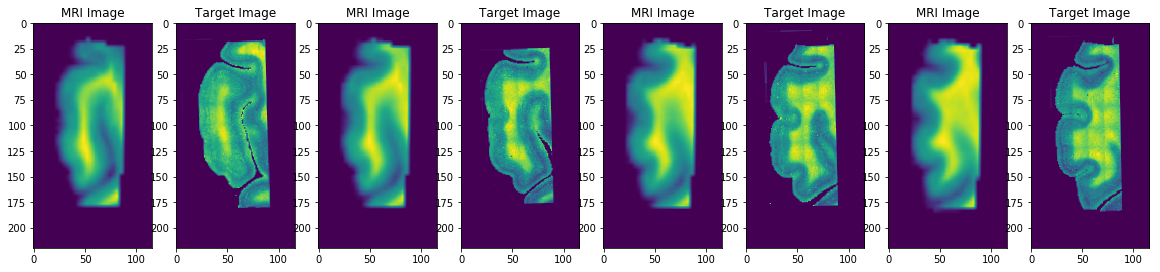

In [28]:
# apply the contrast adjustment to the MRI
#mri_adjusted = (mri_transform_arr - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_translated))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,8,1)
plt.imshow(deformed_mri[:,:,4])
plt.title('MRI Image')
plt.subplot(1,8,2)
plt.imshow(outtarget[:,:,4])
plt.title('Target Image')
plt.subplot(1,8,3)
plt.imshow(deformed_mri[:,:,5])
plt.title('MRI Image')
plt.subplot(1,8,4)
plt.imshow(outtarget[:,:,5])
plt.title('Target Image')
plt.subplot(1,8,5)
plt.imshow(deformed_mri[:,:,6])
plt.title('MRI Image')
plt.subplot(1,8,6)
plt.imshow(outtarget[:,:,6])
plt.title('Target Image')
plt.subplot(1,8,7)
plt.imshow(deformed_mri[:,:,7])
plt.title('MRI Image')
plt.subplot(1,8,8)
plt.imshow(outtarget[:,:,7])
plt.title('Target Image')
plt.show()

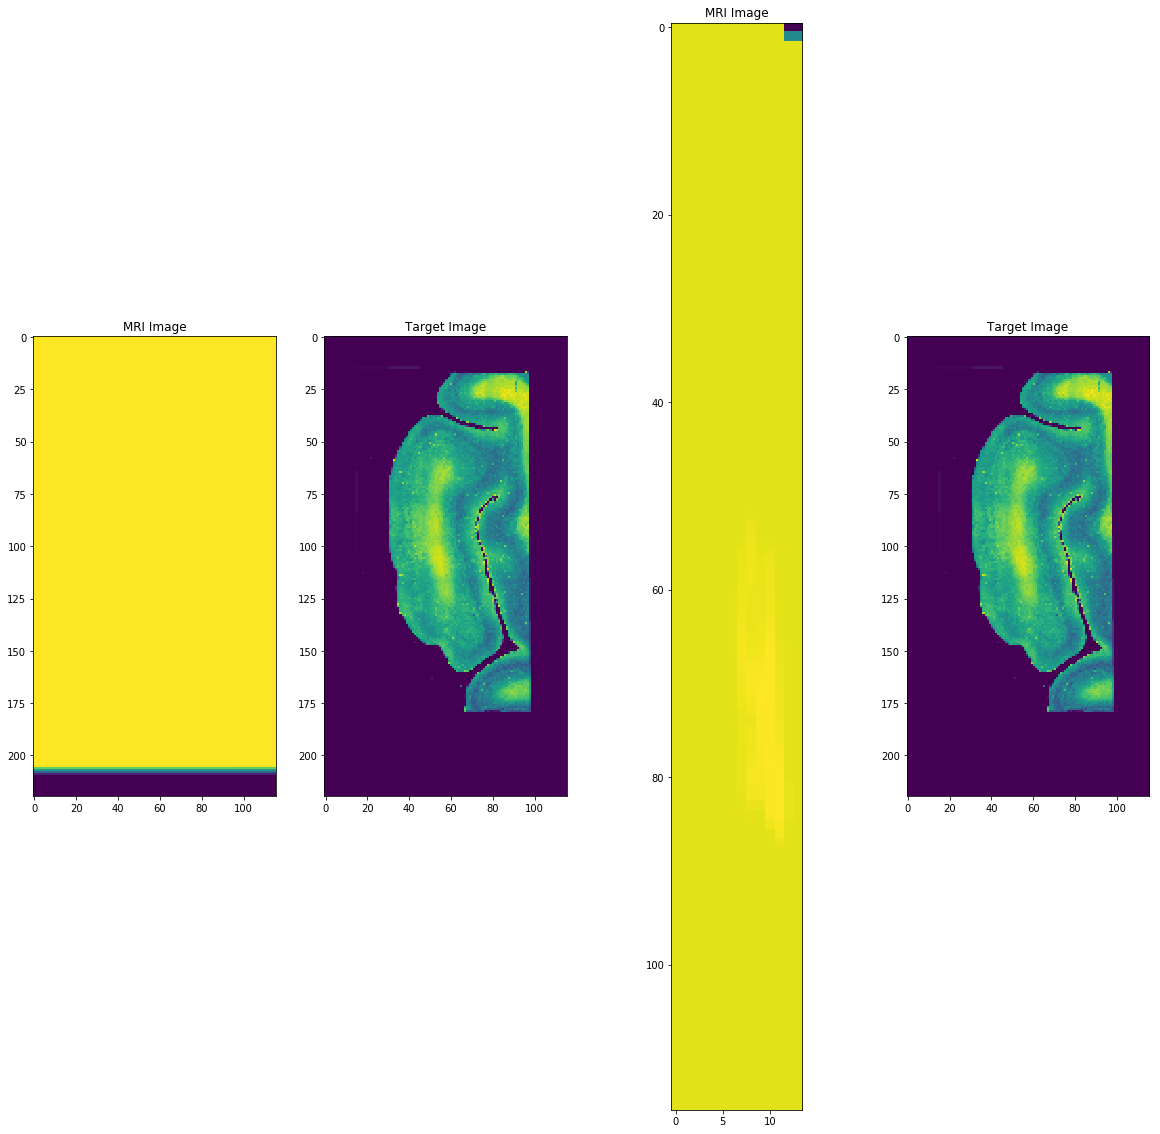

In [51]:
# resample mri back to original target size
# apply the contrast adjustment to the MRI

## previously had an error saying the orignisslsize not defined
orignisslsize = target_resample_arr.shape # not sure about this

mri_adjusted = (mri_resample - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()
mri_adjusted_arr = sitk.GetArrayFromImage(mri_adjusted)
deformed_mri = (lddmm.applyThisTransform(mri_adjusted_arr))[0][-1].cpu().numpy()

mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
mri_sitk.SetSpacing((0.08,0.08,0.08))
mri_sitk_upsampled = sitk.Resample(mri_sitk,
                                   orignisslsize,
                                   sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
plt.figure()
plt.subplot(1,4,1)

plt.imshow(mri_upsampled[:,:,4])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,4])


plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(target_image[:,:,4])
plt.title('Target Image')
plt.show()

In [11]:
print(torch.sum(lddmm.It[0][0] - lddmm.It[0][-1]))

tensor(16490361.)


In [23]:
outmri = nib.AnalyzeImage(mri_upsampled,None)
outmri.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(outmri, '/cis/home/jtrieu/Documents/mri_rigid_upsampled.img')

NameError: name 'mri_upsampled' is not defined

## Do slice alignment

In [24]:
directoryname = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/'

# Grab the indices of the missing slices
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


print(torch.tensor(target_image).type(torch.FloatTensor).cuda().shape)
print(torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda().shape)
#origJ = lddmm.J[0].clone()
epsilonxy = 4e-8
epsilontheta=2e-8
a = None
b = None
theta = None

for i in range(1,8):
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        #epsilonxy = 2e-10
        #epsilontheta=1e-10
        niter = 200
    
    #a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(origJ,lddmm.It[0][-1],niter=niter,dim=1,epsilonxy=epsilonxy, epsilontheta=epsilontheta,norm=0,missingslices=missingslices,sigma_atlas=0.75,sigma_target=10.0,a=a,b=b,theta=theta,min_sigma_atlas=1.0)
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda(),niter=niter,dim=1,norm=0,missingslices=missingslices,sigma_atlas=4.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.04,0.08],epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
    #lddmm.setParams('a',4)
    outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.04,0.08]),2,1).cpu().numpy().astype(np.float32)
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
    # resample the target image
    #outtarget_ds = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0))), [outtarget.shape[0],int(np.round(outtarget.shape[1]/2.0)), outtarget.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    outtarget_np = sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0)))
    outtarget_np.SetSpacing((0.08,0.04,0.08))
    outtarget_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(outtarget_np, deformed_mri.shape, sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))
    
    #lddmm.J[0] = torch.transpose(outtarget,2,1)
    lddmm.J[0] = torch.tensor(outtarget_ds).type(torch.FloatTensor).cuda()
    # reset beta
    if i > 1:
        lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
    
    lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
    #lddmm.GDBeta = torch.tensor(1.0).type(lddmm.params['dtype']).to(device=lddmm.params['cuda'])
    #lddmm.GDBetaAffineR = float(1.0)
    #lddmm.GDBetaAffineT = float(1.0)
    lddmm.setParams('niter',40)
    lddmm.run()
    
    # resample the mri image
    deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()
    mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
    mri_sitk.SetSpacing((0.08,0.08,0.08))
    mri_sitk_upsampled = sitk.Resample(mri_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
    
    ##save
    #outimg = nib.AnalyzeImage(lddmm.It[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'atlas_lddmm_rnaiter' + str(i) + '.img')
    #outimg = nib.AnalyzeImage(np.transpose(outtarget.to('cpu').numpy(),(0,2,1)),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'target_lddmm_rnaiter' + str(i) + '.img')
    ## transform annotation
    #outanno = lddmm.applyThisTransform(anno,interpmode='nearest')
    #outimg = nib.AnalyzeImage(outanno[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'anno_lddmm_rnaiter' + str(i) + '.img')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
torch.Size([220, 116, 14])


NameError: name 'mri_upsampled' is not defined

In [ ]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_upsampled[:,:,100])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[96,:,:])
plt.title('Target Image')
plt.show()

In [ ]:
# write out transforms
aout = a.cpu().numpy()
bout = b.cpu().numpy()
tout = theta.cpu().numpy()
aout = np.delete(aout,missingslices)
bout = np.delete(bout,missingslices)
tout = np.delete(tout,missingslices)
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',aout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',bout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',tout,delimiter='\n')
SAR
# write out rotation center
rotcenter = [outtarget.shape[0]/2.0*0.08, outtarget.shape[2]/2.0*0.08]
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',rotcenter,delimiter='\n')

# write out the reconstructed target image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = [0.08,0.04,0.08]marmoset
nib.save(outimg, '/cis/home/jtrieu/Documents/M519_orig_target_STS.img')

In [ ]:
aout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',delimiter='\n')
bout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',delimiter='\n')
tout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',delimiter='\n')
rotcenter = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',delimiter='\n')
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_XForm_matrix.txt','w')
for i in range(len(aout)):
    file.write(str(np.cos(tout[i])) + ',' + str(-1*np.sin(tout[i])) + ',' + str(np.sin(tout[i])) + ',' + str(np.cos(tout[i])) + ',' + str(aout[i]) + ',' + str(bout[i]) + ',' + str(rotcenter[0]) + ',' + str(rotcenter[1]) + '\n')

file.close()

## Map atlas to reconstructed target

In [ ]:
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

# pad the atlas and the target
templatepadsize = [max(target_ds.shape[0],template_image.shape[0]), max(int(np.round(target_image.shape[1]/2.0)),template_image.shape[1]), max(target_ds.shape[2],template_image.shape[2])]
target_padded = np.zeros(templatepadsize)
target_padded[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]] = np.copy(target_ds)
template_padded = np.zeros(templatepadsize)
template_padded[0:template_image.shape[0],0:template_image.shape[1],0:template_image.shape[2]] = np.copy(template_image)

## Do affine alignment

In [ ]:

lddmm = torch_lddmm.LDDMM(template=[template_padded],target=[target_padded],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,epsilonL=4e-8,epsilonT=8e-6)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()

In [ ]:
lddmm.setParams('do_affine',1)
#lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
#lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
lddmm.setParams('epsilonL',4e-8)
lddmm.setParams('epsilonT',8e-6)
lddmm.setParams('niter',500)
lddmm.run()

In [ ]:

plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_padded[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_padded[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[96,:,:])
plt.title('Deformed Template')
plt.show()

In [ ]:

# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_padded.shape[0]/2.0) + '\n')
file.write(str(target_padded.shape[1]/2.0) + '\n')
file.write(str(target_padded.shape[2]/2.0) + '\n')
file.close()

## crop images back to original size

In [ ]:
template_affine = lddmm.It[0][-1].cpu().numpy()[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(template_affine,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img')

# transform the annotation
anno = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/annotation_80_flip.img').get_data().astype(np.float32))
anno_padded = np.zeros(templatepadsize)
anno_padded[0:anno.shape[0],0:anno.shape[1],0:anno.shape[2]] = np.copy(anno)

deformed_anno,_,_,_ = lddmm.applyThisTransform(anno_padded,interpmode='nearest')
deformed_anno = (deformed_anno[-1].cpu().numpy())[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(deformed_anno,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation_affine.img')

## Do LDDMM

In [ ]:

template_affine = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img').get_data().astype(np.float32)
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
#template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

lddmm = torch_lddmm.LDDMM(template=[template_affine],target=[target_ds],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()


In [ ]:

anno_sitk = sitk.GetImageFromArray(np.transpose(deformed_anno,(2,1,0)))
anno_sitk.SetSpacing((0.08,0.08,0.08))
anno_us = sitk.Resample(anno_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkNearestNeighbor,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
anno_us = np.transpose(sitk.GetArrayFromImage(anno_us),(2,1,0))
anno_out = nib.AnalyzeImage(anno_us,None)
anno_out.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(anno_out,'/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation.img')

In [ ]:
evels = np.unique(anno_us[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(target_image[:,:,100],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[:,:,100]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(anno_us[96,:,:])
plt.subplot(1,2,2)
plt.imshow(target_image[96,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[96,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()

In [ ]:

# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt2.npy',vt2)

In [ ]:
## Warp MRI to reconstructed target

In [ ]:
target_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img'
mri_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_mri_full.img'

target_image = nib.load(target_file_name).get_data().astype(np.float32)
mri_image = nib.load(mri_file_name).get_data().astype(np.float32)

mripadsize = [max(target_image.shape[0],int(np.round(mri_image.shape[0]*0.06/0.08))), max(int(np.round(target_image.shape[1]/2.0)),int(np.round(mri_image.shape[1]*0.06/0.08))), max(target_image.shape[2],int(np.round(mri_image.shape[2]*0.06/0.08)))]

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,mripadsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_sitk = sitk.ReadImage(mri_file_name)
print(mri_sitk.GetSize())
mri_sitk_resample = sitk.Resample(mri_sitk,target_resample.shape,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(mri_sitk_resample.GetSize())
mri_resample = np.transpose(sitk.GetArrayFromImage(mri_sitk_resample),(2,1,0))
print(mri_resample.shape)

#target_padded = np.zeros(mripadsize)
#target_padded[0:target_image.shape[0],0:target_image.shape[1],0:target_image.shape[2]] = np.copy(target_image)
#mri_padded = np.zeros(mripadsize)
#mri_padded[0:mri_image.shape[0],0:mri_image.shape[1],0:mri_image.shape[2]] = np.copy(mri_image)

In [ ]:
dx=[0.08,0.08,0.08]
lddmm = torch_lddmm.LDDMM(template=[mri_resample],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1)
lddmm.run()

In [ ]:
lddmm.setParams('do_affine',1)
lddmm.run()


In [ ]:
# save transforms
# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_resample.shape[0]/2.0) + '\n')
file.write(str(target_resample.shape[1]/2.0) + '\n')
file.write(str(target_resample.shape[2]/2.0) + '\n')
file.close()

In [ ]:
# crop the MRI back to original target size

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,[target_sitk.GetSize()[0],int(np.round(target_sitk.GetSize()[1]/2.0)),target_sitk.GetSize()[2]],sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_affine = lddmm.It[0][-1].cpu().numpy()
mri_affine = mri_affine[0:target_resample.shape[0], 0:target_resample.shape[1],0:target_resample.shape[2]]

In [ ]:

lddmm = torch_lddmm.LDDMM(template=[mri_affine],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()


In [ ]:
deformed_mri,_,_,_ = lddmm.applyThisTransform(mri_affine,interpmode='bilinear')
deformed_mri = deformed_mri[-1].cpu().numpy()

plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_resample[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(deformed_mri[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_resample[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(deformed_mri[96,:,:])
plt.title('Deformed Template')
plt.show()

out_mri = nib.AnalyzeImage(deformed_mri, None)
out_mri.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(out_mri, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_lddmm.img')

In [ ]:
# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt2.npy',vt2)